In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T

from imageio import imread
import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [ ]:
vggnet = torchvision.models.vgg19(pretrained=True)

for p in vggnet.parameters():
    p.requires_grad = False

vggnet.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:11<00:00, 51.1MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
vggnet.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [ ]:
img4content = imread('https://upload.wikimedia.org/wikipedia/commons/6/61/De_nieuwe_vleugel_van_het_Stedelijk_Museum_Amsterdam.jpg')
img4style   = imread('https://upload.wikimedia.org/wikipedia/commons/c/c5/Edvard_Munch%2C_1893%2C_The_Scream%2C_oil%2C_tempera_and_pastel_on_cardboard%2C_91_x_73_cm%2C_National_Gallery_of_Norway.jpg')

# initialize the target image and random numbers
img4target = np.random.randint(low=0,high=255,size=img4content.shape,dtype=np.uint8)

print(img4content.shape)
print(img4target.shape)
print(img4style.shape)

<ipython-input-4-e6df82ac5b1e>:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img4content = imread('https://upload.wikimedia.org/wikipedia/commons/6/61/De_nieuwe_vleugel_van_het_Stedelijk_Museum_Amsterdam.jpg')
<ipython-input-4-e6df82ac5b1e>:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img4style   = imread('https://upload.wikimedia.org/wikipedia/commons/c/c5/Edvard_Munch%2C_1893%2C_The_Scream%2C_oil%2C_tempera_and_pastel_on_cardboard%2C_91_x_73_cm%2C_National_Gallery_of_Norway.jpg')


(1675, 3000, 3)
(1675, 3000, 3)
(4000, 3223, 3)


In [ ]:
Ts = T.Compose([T.ToTensor(),
                T.Resize(256),
                T.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
                ])

img4content = Ts(img4content).unsqueeze(0).to(device)
img4style = Ts(img4style).unsqueeze(0).to(device)
img4target = Ts(img4target).unsqueeze(0).to(device)

print(img4content.shape)
print(img4target.shape)
print(img4style.shape)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([1, 3, 256, 458])
torch.Size([1, 3, 256, 458])
torch.Size([1, 3, 317, 256])


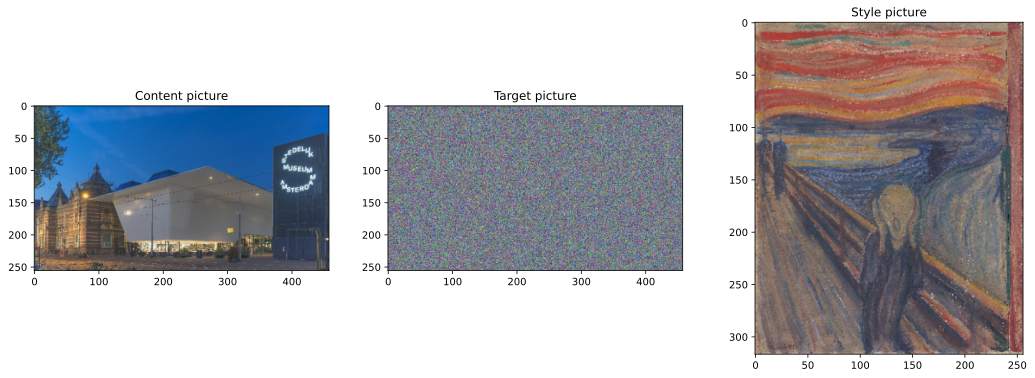

In [ ]:
fig, ax = plt.subplots(1, 3, figsize = (18, 6))

pic = img4content.cpu().squeeze().numpy().transpose((1, 2, 0))
pic = (pic-np.min(pic))/(np.max(pic) - np.min(pic))
ax[0].imshow(pic)
ax[0].set_title('Content picture')

pic = img4target.cpu().squeeze().numpy().transpose((1, 2, 0))
pic = (pic-np.min(pic))/(np.max(pic) - np.min(pic))
ax[1].imshow(pic)
ax[1].set_title('Target picture')

pic = img4style.cpu().squeeze().numpy().transpose((1, 2, 0))
pic = (pic-np.min(pic))/(np.max(pic) - np.min(pic))
ax[2].imshow(pic)
ax[2].set_title('Style picture')

plt.show()

In [ ]:
def getFeatureMapActs(img, net):

    # initialize feature maps as a list
    featuremaps = []
    featurenames = []

    convLayerIdx = 0


    # loop through all layers in features block
    for layernum in range(len(net.features)):

        # print(layernum, net.features[layernum])

        # process the image through this layer
        img = net.features[layernum](img)

        if 'Conv2d' in str(net.features[layernum]):
            featuremaps.append(img)
            featurenames.append('ConvLayer_' + str(convLayerIdx))
            convLayerIdx += 1

    return featuremaps, featurenames




In [ ]:
# A function that returns gram matrix of the feature activation map
def gram_matrix(M):

    _, chans, height, width = M.shape

    M = M.reshape(chans, height*width)
    gram = torch.mm(M, M.t())/(chans*height*width)

    return gram

In [ ]:
featmaps, featnames = getFeatureMapActs(img4content, vggnet)

for i in range(len(featnames)):
    print('Feature map "%s" is size %s ' %(featnames[i], featmaps[i].shape))

Feature map "ConvLayer_0" is size torch.Size([1, 64, 256, 458]) 
Feature map "ConvLayer_1" is size torch.Size([1, 64, 256, 458]) 
Feature map "ConvLayer_2" is size torch.Size([1, 128, 128, 229]) 
Feature map "ConvLayer_3" is size torch.Size([1, 128, 128, 229]) 
Feature map "ConvLayer_4" is size torch.Size([1, 256, 64, 114]) 
Feature map "ConvLayer_5" is size torch.Size([1, 256, 64, 114]) 
Feature map "ConvLayer_6" is size torch.Size([1, 256, 64, 114]) 
Feature map "ConvLayer_7" is size torch.Size([1, 256, 64, 114]) 
Feature map "ConvLayer_8" is size torch.Size([1, 512, 32, 57]) 
Feature map "ConvLayer_9" is size torch.Size([1, 512, 32, 57]) 
Feature map "ConvLayer_10" is size torch.Size([1, 512, 32, 57]) 
Feature map "ConvLayer_11" is size torch.Size([1, 512, 32, 57]) 
Feature map "ConvLayer_12" is size torch.Size([1, 512, 16, 28]) 
Feature map "ConvLayer_13" is size torch.Size([1, 512, 16, 28]) 
Feature map "ConvLayer_14" is size torch.Size([1, 512, 16, 28]) 
Feature map "ConvLayer_15

In [ ]:
# lets see what content image looks like

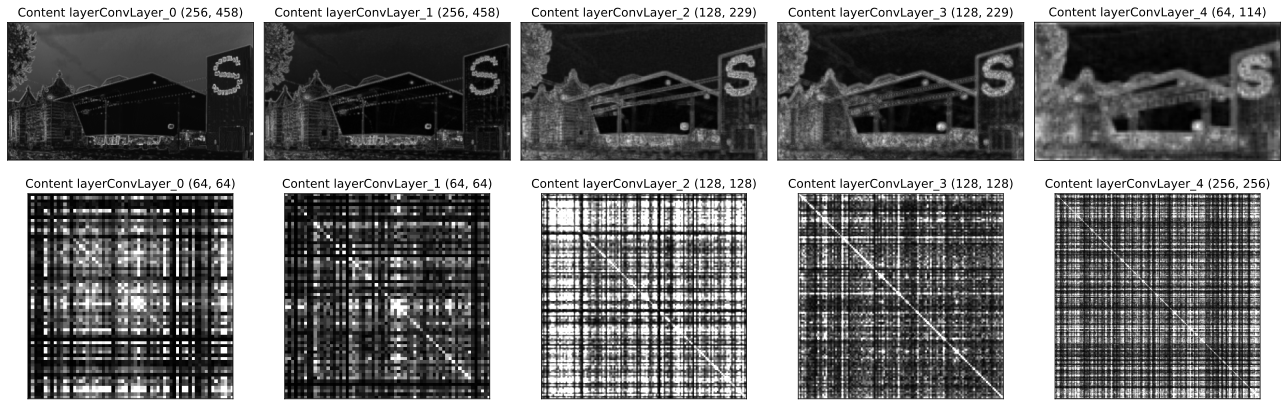

In [ ]:
contentFeatureMaps, contentFeatureNames = getFeatureMapActs(img4content, vggnet)

fig, axs = plt.subplots(2, 5, figsize = (18, 6))

for i in range(5):
    # print('Content Feature ' + str(np.mean(contentFeatureMaps[i].cpu().squeeze().numpy(), axis = 0).shape))
    pic = np.mean(contentFeatureMaps[i].cpu().squeeze().numpy(), axis = 0)
    pic = (pic - np.min(pic))/(np.max(pic) - np.min(pic))

    axs[0, i].imshow(pic, cmap = 'gray')
    axs[0, i].set_title('Content layer' + str(contentFeatureNames[i]) + ' ' + str(pic.shape))
    axs[0, i].set_xticks([])
    axs[0, i].set_yticks([])


    # gram matrix
    pic = gram_matrix(contentFeatureMaps[i]).cpu().numpy()
    pic = (pic - np.min(pic))/(np.max(pic) - np.min(pic))
    axs[1, i].imshow(pic, cmap = 'gray', vmax = .1)
    axs[1, i].set_title('Content layer' + str(contentFeatureNames[i])+' ' + str(pic.shape))
    axs[1, i].set_xticks([])
    axs[1, i].set_yticks([])


plt.tight_layout()
plt.show()


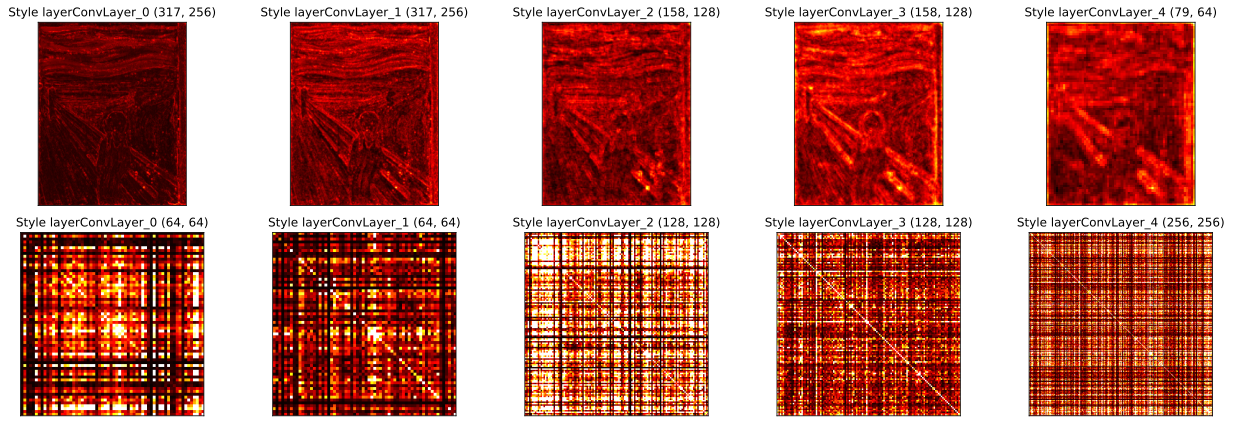

In [ ]:
styleFeatureMaps, styleFeatureNames = getFeatureMapActs(img4style, vggnet)

fig, axs = plt.subplots(2, 5, figsize = (18, 6))

for i in range(5):
    # print('Content Feature ' + str(np.mean(styleFeatureMaps[i].cpu().squeeze().numpy(), axis = 0).shape))
    pic = np.mean(styleFeatureMaps[i].cpu().squeeze().numpy(), axis = 0)
    pic = (pic - np.min(pic))/(np.max(pic) - np.min(pic))

    axs[0, i].imshow(pic, cmap = 'hot')
    axs[0, i].set_title('Style layer' + str(styleFeatureNames[i]) + ' ' + str(pic.shape))
    axs[0, i].set_xticks([])
    axs[0, i].set_yticks([])


    # gram matrix
    pic = gram_matrix(contentFeatureMaps[i]).cpu().numpy()
    pic = (pic - np.min(pic))/(np.max(pic) - np.min(pic))
    axs[1, i].imshow(pic, cmap = 'hot', vmax = .1)
    axs[1, i].set_title('Style layer' + str(styleFeatureNames[i])+' ' + str(pic.shape))
    axs[1, i].set_xticks([])
    axs[1, i].set_yticks([])


plt.tight_layout()
plt.show()


In [ ]:
# which layers to use
layers4content = ['ConvLayer_1', 'ConvLayer_4']
layers4style = ['ConvLayer_1', 'ConvLayer_2', 'ConvLayer_3','ConvLayer_4', 'ConvLayer_5']
weights4style = [1, .5, .5, .2, .1]

In [ ]:
# make a copy of the target image and push to gpu
target = img4target.clone()
target.requires_grad = True
target = target.to(device)
styleScaling = 1e6

numepochs = 1500

optimizer =torch.optim.RMSprop([target], lr = .005)


for epochi in range(numepochs):

    # extract the target feature maps
    targetFeatureMaps, targetFeatureNames = getFeatureMapActs(target, vggnet)

    # initialize the individual loss components
    styleLoss = 0
    contentLoss = 0

    # loop over layers
    for layeri in range(len(targetFeatureNames)):

        if targetFeatureNames[layeri] in layers4content:
            # compute the content loss
            contentLoss += torch.mean((targetFeatureMaps[layeri] - contentFeatureMaps[layeri]) ** 2)

        if targetFeatureNames[layeri] in layers4style:

            Gtarget = gram_matrix(targetFeatureMaps[layeri])
            Gstyle = gram_matrix(styleFeatureMaps[layeri])

            styleLoss += torch.mean((Gtarget-Gstyle)**2 )* weights4style[layers4style.index(targetFeatureNames[layeri])]


    # combined loss
    combiloss = styleScaling*styleLoss + contentLoss

    # finally ready for backprop!
    optimizer.zero_grad()
    combiloss.backward()
    optimizer.step()



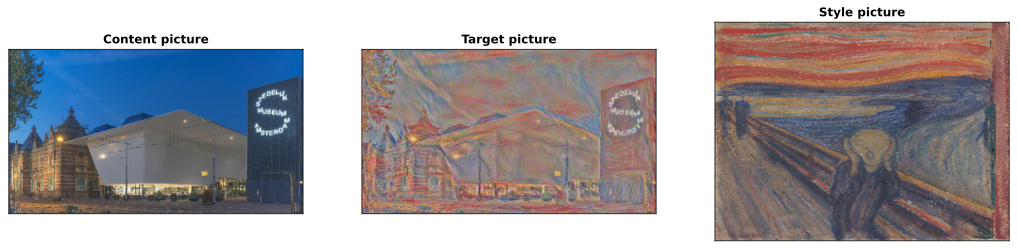

In [ ]:
# the "after" pic
fig,ax = plt.subplots(1,3,figsize=(18,11))

pic = img4content.cpu().squeeze().numpy().transpose((1,2,0))
pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))
ax[0].imshow(pic)
ax[0].set_title('Content picture',fontweight='bold')
ax[0].set_xticks([])
ax[0].set_yticks([])

pic = torch.sigmoid(target).cpu().detach().squeeze().numpy().transpose((1,2,0))
ax[1].imshow(pic)
ax[1].set_title('Target picture',fontweight='bold')
ax[1].set_xticks([])
ax[1].set_yticks([])

pic = img4style.cpu().squeeze().numpy().transpose((1,2,0))
pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))
ax[2].imshow(pic,aspect=.6)
ax[2].set_title('Style picture',fontweight='bold')
ax[2].set_xticks([])
ax[2].set_yticks([])

plt.show()